In [21]:
from __future__ import annotations
import sys; sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2


# python
import os
import ssl
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from pathlib import Path
from inspect import cleandoc

# utils
from utils import Constants
from modules.preprocesing import preprocess

from wordcloud import WordCloud

# text
import re
import spacy
import unidecode
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# models
import umap
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

# sklearn
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity, cosine_distances
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Metrics
from sklearn.metrics import silhouette_score

# stat
from scipy import stats

# statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# typings
from pandas import DataFrame as PandasDF
from typing import List, Dict, Union

# setup
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)
# decimals
np.set_printoptions(precision=6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# cargar el dataset sklearn
if not os.environ.get('CI'):
    ssl._create_default_https_context =\
        ssl._create_unverified_context
          
# rutas absolutas
here: Path = Path.cwd().absolute().parent
data: Path = here / 'data'
poetry_fundation_cleaned: Path = data / 'CleanedPoetryFoundationData.csv'
cv_poetry: Path = data / 'vallejo_poems_en.csv'

In [3]:
setup_load:Dict = dict(
    sep=Constants.PIPE_STR,
    quotechar='"',
    quoting=csv.QUOTE_NONNUMERIC,
    encoding=Constants.ENCODING
)

if not poetry_fundation_cleaned.is_file() or not cv_poetry.is_file():
    raise FileNotFoundError(
        cleandoc(f'''
        El archivo {poetry_fundation_cleaned} no existe.
        Por favor, descargue el archivo desde:
        https://www.kaggle.com/datasets/abhinavwalia95/poetryfoundationorg
        y coloquelo en la carpeta data.
        ''')
    )
    
poetry_df: PandasDF = (
    pd.read_csv(
        str(poetry_fundation_cleaned), 
        **setup_load
    ).dropna(subset=['title'])
)

cv_df: PandasDF = (
        pd.read_csv(
        str(cv_poetry), 
        **setup_load
    )
)

cv_df[['title', 'poem']] = (
        cv_df[['title', 'poem']]
        .apply(lambda col: col.astype(str).apply(preprocess))
    )

poetry_df = poetry_df.loc[~poetry_df.poem.isna(),:]

In [4]:
display(poetry_df.head(3))

,title,poem,poet,tags
0,invis fish,invis fish swim ghost ocean describ wave sand waterworn rock soon fish learn walk human come ashor paint dream die stone later later ocean floor punctuat chevi truck carri dreamer decend go store,joy harjo,"['living', 'time brevity', 'relationships', 'family ancestors', 'nature', 'landscapes pastorals', 'seas', 'rivers', 'streams', 'social commentaries', 'history politics']"
1,not bother earth spirit,not bother earth spirit live work stori oldest stori world delic chang see watch invit coffe warm bread oblig stay listen ordinari stori endur earthquak lightn death love blind beauti stori compel want leav trap stone finger escap,joy harjo,"['religion', 'the spiritual', 'mythology folklore', 'fairytales legends']"
2,hour consid hydrangea,hour consid hydrangea salt sand plant variet question variet diet mother know pound feel like lose lose ye sens possibl beauti grow extern extern beauti beauti occur surfac plant sun darken skin child small beauti obviou beauti hand swell bite spread insect venom small appear feel smash skull floor scream hold lap kitchen floor open freezer press pack frozen clay forehead like cold obviou hydrangea walk push child stroller walk push haul lift have bodi adjunct bodi compos errand weight tender small power imagin feel small weight pound like interf twitch muscl bodi object mother confus middleag mother littl spare flesh feel inch major muscl pull graviti weight child sleep hour think hydrangea let man look stop brush drowsi child littl eye face bare consid mother consid miss subtl power differenti time mass apprehen,simon white,"['living', 'parenthood', 'the body', 'the mind', 'nature', 'trees flowers']"


In [5]:
display(cv_df.head(3))

,title,poem
0,black herald,blow life power not know blow god hatr backlash suffer dam soul not know open dark furrow fierce face strong mayb hors barbar attila black herald death send deep abyss soul christ rever faith destini blasphem gori blow crackl bread burnsup oven door man poor poor turn eye slap shoulder call turn craze eye live dam like pond guilt gaze blow life power not know
1,black stone white stone,shall die pari rainstorm day rememb shall die pari bother doubtless thursday like today autumn shall thursday today thursday line set shoulder evil like today turn head journey way cesar vallejo dead strike hit hard stick hard end rope wit thursday shoulder bone loneli rain road
2,pari octob poem,leav bench away pant great situat action number split leav champ elyse strang alley moon make turn death goe away cradl leav surround peopl cut loo human resembl turn dispatch shadow away remain creat alibi shoe eyelet mud bend elbow button shirt


In [6]:
new_poems_df: PandasDF = pd.concat([
    poetry_df[['title', 'poem']],
    cv_df[['title', 'poem']]
])

In [7]:
# 2. Vectorizar el texto
tfidf = TfidfVectorizer(max_features=5000) # Limitar a 5000 palabras más importantes
tfidf_matrix  = tfidf.fit_transform(new_poems_df.poem)

In [8]:
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(), 
    index=new_poems_df.title, 
    columns=tfidf.get_feature_names_out()
)
display(df_tfidf)

abandon  abid  abil  abl  abraham  abroad  absenc  \
title                                                                        
invis fish                   0.0   0.0   0.0  0.0      0.0     0.0     0.0   
not bother earth spirit      0.0   0.0   0.0  0.0      0.0     0.0     0.0   
hour consid hydrangea        0.0   0.0   0.0  0.0      0.0     0.0     0.0   
scar                         0.0   0.0   0.0  0.0      0.0     0.0     0.0   
remain                       0.0   0.0   0.0  0.0      0.0     0.0     0.0   
...                          ...   ...   ...  ...      ...     ...     ...   
fear                         0.0   0.0   0.0  0.0      0.0     0.0     0.0   
black herald                 0.0   0.0   0.0  0.0      0.0     0.0     0.0   
black stone white stone      0.0   0.0   0.0  0.0      0.0     0.0     0.0   
pari octob poem              0.0   0.0   0.0  0.0      0.0     0.0     0.0   
xiii                         0.0   0.0   0.0  0.0      0.0     0.0     0.0   

                         absent  absolut  absorb  abstract  absurd  abund  \
title                                                                       
invis fish                  0.0      0.0     0.0       0.0     0.0    0.0   
not bother earth spirit     0.0      0.0     0.0       0.0     0.0    0.0   
hour consid hydrangea       0.0      0.0     0.0       0.0     0.0    0.0   
scar                        0.0      0.0     0.0       0.0     0.0    0.0   
remain                      0.0      0.0     0.0       0.0     0.0    0.0   
...                         ...      ...     ...       ...     ...    ...   
fear                        0.0      0.0     0.0       0.0     0.0    0.0   
black herald                0.0      0.0     0.0       0.0     0.0    0.0   
black stone white stone     0.0      0.0     0.0       0.0     0.0    0.0   
pari octob poem             0.0      0.0     0.0       0.0     0.0    0.0   
xiii                        0.0      0.0     0.0       0.0     0.0    0.0   

                         abus     abyss  accent  accept  access  accid  \
title                                                                    
invis fish                0.0  0.000000     0.0     0.0     0.0    0.0   
not bother earth spirit   0.0  0.000000     0.0     0.0     0.0    0.0   
hour consid hydrangea     0.0  0.000000     0.0     0.0     0.0    0.0   
scar                      0.0  0.000000     0.0     0.0     0.0    0.0   
remain                    0.0  0.000000     0.0     0.0     0.0    0.0   
...                       ...       ...     ...     ...     ...    ...   
fear                      0.0  0.000000     0.0     0.0     0.0    0.0   
black herald              0.0  0.161126     0.0     0.0     0.0    0.0   
black stone white stone   0.0  0.000000     0.0     0.0     0.0    0.0   
pari octob poem           0.0  0.000000     0.0     0.0     0.0    0.0   
xiii                      0.0  0.000000     0.0     0.0     0.0    0.0   

                         accident  accompani  accomplish  accord  account  \
title                                                                       
invis fish                    0.0        0.0         0.0     0.0      0.0   
not bother earth spirit       0.0        0.0         0.0     0.0      0.0   
hour consid hydrangea         0.0        0.0         0.0     0.0      0.0   
scar                          0.0        0.0         0.0     0.0      0.0   
remain                        0.0        0.0         0.0     0.0      0.0   
...                           ...        ...         ...     ...      ...   
fear                          0.0        0.0         0.0     0.0      0.0   
black herald                  0.0        0.0         0.0     0.0      0.0   
black stone white stone       0.0        0.0         0.0     0.0      0.0   
pari octob poem               0.0        0.0         0.0     0.0      0.0   
xiii                          0.0        0.0         0.0     0.0      0.0   

                         accumul  accur  ac

In [20]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.      , 0.017821, 0.046964, ..., 0.017969, 0.021071, 0.010993],
       [0.017821, 1.      , 0.030733, ..., 0.0316  , 0.040423, 0.018561],
       [0.046964, 0.030733, 1.      , ..., 0.007552, 0.      , 0.018709],
       ...,
       [0.017969, 0.0316  , 0.007552, ..., 1.      , 0.012857, 0.01698 ],
       [0.021071, 0.040423, 0.      , ..., 0.012857, 1.      , 0.023382],
       [0.010993, 0.018561, 0.018709, ..., 0.01698 , 0.023382, 1.      ]])

In [10]:
def recomendador(title, cosine_sim=cosine_sim, df=new_poems_df):
    
    #Paso 2
    df = df.reset_index()
    indices = pd.Series(df.index, index=df.title).drop_duplicates()
    #Paso 3
    idx = indices[title]

    #Paso 4
    sim_scores = list(enumerate(cosine_sim[idx]))

    #Paso 5
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #Paso 6
    sim_scores = sim_scores[1:11]

    _indices = [i[0] for i in sim_scores]

    #Paso 7
    return pd.DataFrame(df.title.iloc[_indices])

In [11]:
display(recomendador('black herald'))

,title
623,aim song
3259,way wind blow
1822,keumganggul diamond cave
9313,ballad salvat armi
6145,fortuna
5875,american histori
11911,princess splendour fall castl wall
1644,curs name
5126,sea
3336,book dead dam


In [12]:
def recommendation_corr(
    query_title: str,
    corr_matrix: pd.DataFrame,
    top_n: int = 5
) -> pd.DataFrame:
    """
    Genera recomendaciones basadas en correlación de Pearson entre documentos.

    Args:
        query_title (str): Documento de referencia.
        corr_matrix (pd.DataFrame): Matriz de correlaciones.
        top_n (int): Número de recomendaciones a devolver.

    Returns:
        pd.DataFrame: Recomendaciones con puesto, título y similitud.
    """
    if query_title not in corr_matrix.columns:
        raise ValueError(f"El título '{query_title}' no está en la matriz de correlación.")

    # Extraer correlaciones con el documento de referencia
    sim_scores = corr_matrix[query_title].drop(query_title)

    # Ordenar de mayor a menor correlación
    sim_scores = sim_scores.sort_values(ascending=False).head(top_n)

    return pd.DataFrame({
        "Puesto": range(Constants.ONE, len(sim_scores) + Constants.ONE),
        "Recomendación": sim_scores.index,
        "Similitud": sim_scores.values
    })


corr_matrix = df_tfidf.T.corr(method="pearson")

recom_tfidf_corr = recommendation_corr(
    query_title='black herald',
    corr_matrix=corr_matrix,
    top_n=5
)

display(recom_tfidf_corr)

,Puesto,Recomendación,Similitud
0,1,aim song,0.226851
1,2,way wind blow,0.200077
2,3,keumganggul diamond cave,0.197809
3,4,ballad salvat armi,0.195655
4,5,fortuna,0.194555


In [12]:
# Modelo LDA con sklearn
lda_model = LatentDirichletAllocation(
    n_components=7,
    random_state=0
)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Identificar tema principal del poema 'black herald'
idx_cuento = new_poems_df[new_poems_df.title == 'black herald'].index[0]
tema_principal = lda_topics[idx_cuento].argmax()

# Probabilidades de pertenecer al tema principal
prob_tema_principal = lda_topics[:, tema_principal]

# Construir ranking de recomendaciones
df_recom = new_poems_df[["title"]].copy()
df_recom["prob_tema"] = prob_tema_principal

# eliminar el mismo poema 'black herald'
df_recom = df_recom[df_recom["title"] != 'black herald']

# ordenar por mayor probabilidad
df_recom = df_recom.sort_values("prob_tema", ascending=False)

# top N recomendaciones
top_recom = df_recom.head(5).reset_index(drop=True)
top_recom.insert(0, "Puesto", range(1, len(top_recom) + 1))

display(top_recom)

,Puesto,title,prob_tema
0,1,scene life capit,0.972802
1,2,homo antarcticu,0.964357
2,3,east carthag idyl,0.963567
3,4,letter america abecedari,0.962815
4,5,heart needl,0.962639


In [13]:
# LDA  “top palabras por tópico”)
feature_names = tfidf.get_feature_names_out()
n_top = 10
top_words = []
for t, topic in enumerate(lda_model.components_):
    top_idx = topic.argsort()[::-1][:n_top]
    words = [feature_names[i] for i in top_idx]
    top_words.append((t, words))

display(
    pd.DataFrame({
        f"topic_{t}": words for t, words in top_words
    })
)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,firefli,wi,thi,like,sustain,knowledg,like
1,ex,na,love,not,jack,wait,water
2,mosquito,ha,thou,know,era,se,tree
3,milk,mari,shall,say,cuckoo,articul,light
4,scarlet,cometh,thee,come,war,faustin,wind
5,exhaust,wad,heart,think,van,wayn,white
6,deaf,hym,man,man,site,beef,come
7,histor,theyr,sweet,time,unreal,crispin,fall
8,buddha,laura,soul,love,rever,mirror,dark
9,greet,st,day,want,cram,seek,leav


In [ ]:
X = tfidf_matrix

In [9]:
# Modelo KMeans (+ silhouette)
def fit_kmeans_range(X, kmin=2, kmax=12, random_state=42):
    best = {"k": None, "sil": -1, "model": None, "labels": None}
    sils = []
    for k in range(kmin, kmax+1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels, metric="cosine")
        sils.append((k, sil))
        if sil > best["sil"]:
            best = {"k": k, "sil": sil, "model": km, "labels": labels}
    return best, sils

X = tfidf_matrix
best_km, km_sils = fit_kmeans_range(X)
new_poems_df["cluster_km"] = best_km["labels"]
best_km["k"], best_km["sil"]

(3, 0.002785452022155599)

In [11]:
# Modelo Gaussian Mixture (GMM)

X_dense = X.toarray() if hasattr(X, "toarray") else X
Xpca = PCA(n_components=50, random_state=42).fit_transform(X_dense)

gmm = GaussianMixture(n_components=best_km["k"], covariance_type="full", random_state=42)
gmm_labels = gmm.fit_predict(Xpca)
new_poems_df["cluster_gmm"] = gmm_labels

In [16]:
# Moddel Agglomerative (en distancia coseno)

D = cosine_distances(X)         # distancia = 1 - coseno
agg = AgglomerativeClustering(n_clusters=best_km["k"], metric="precomputed", linkage="average")
agg_labels = agg.fit_predict(D)
new_poems_df["cluster_agg"] = agg_labels

In [19]:
# Model DBSCAN (en espacio reducido con UMAP/t-SNE)
umap_ok = True
try:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X2 = reducer.fit_transform(X)  # acepta sparse
except Exception:
    umap_ok = False
    X2 = TSNE(n_components=2, random_state=42, metric="cosine").fit_transform(X.toarray())

db = DBSCAN(eps=0.5, min_samples=5, metric="euclidean").fit(X2)
new_poems_df["cluster_dbscan"] = db.labels_

/Users/ronaldmendoza/Documents/Documents/Repos/GitHub/projects/_hubertronald/VersoVector/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


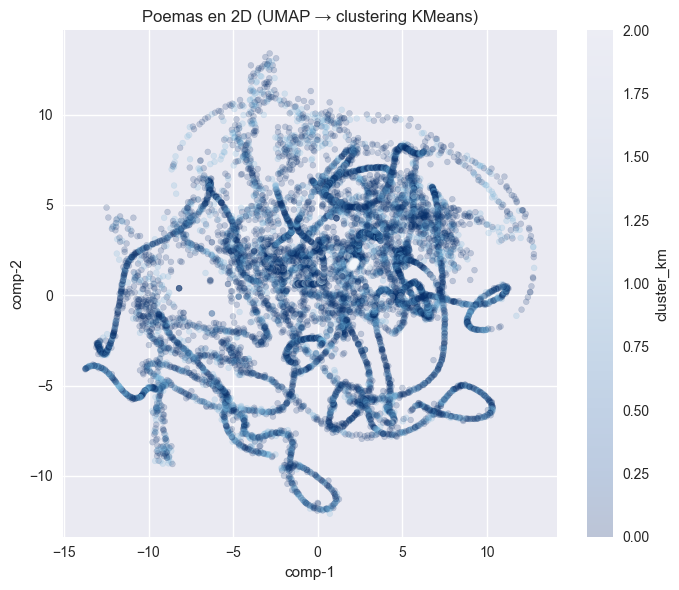

In [39]:
# Visualización 2D (matplotlib)
fig, ax = plt.subplots(figsize=(7,6))
sc = ax.scatter(X2[:,0], X2[:,1], c=new_poems_df["cluster_km"], s=18, alpha=0.2, cmap="Blues_r")
ax.set_title("Poemas en 2D ({} → clustering KMeans)".format("UMAP" if umap_ok else "t-SNE"))
ax.set_xlabel("comp-1"); ax.set_ylabel("comp-2")
plt.colorbar(sc, ax=ax, label="cluster_km")
plt.tight_layout(); plt.show()

### La apariencia “orgánica”:

Las ramificaciones son poemas que comparten similitudes con varios grupos → quedan como “puentes” o “brazos”.

Los nudos o concentraciones (zonas densas) son grupos de poemas con vocabulario/emoción muy parecida.

El hecho de que se vean como filamentos o bacterias es porque UMAP estira el espacio para mostrar continuidad entre regiones.

### Interpretación práctica

Si en el corpus hay poemas con temas/emociones muy conectados (por ejemplo, dolor ↔ muerte ↔ desesperanza en Vallejo), UMAP los hilvana en curvas continuas.

Si fueran más disjuntos (ej. poemas amorosos vs poemas políticos), verías islas separadas, no ramificaciones.

En poesía esto es natural: los temas no son rígidos, sino que fluyen de uno a otro. El gráfico refleja precisamente esa transición semántica difusa.

In [22]:
# Similitud coseno (matriz y top-k vecinos)

# matriz de similitud (calculada)
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# top-k por coseno (equivalente a recomendador)
nn = NearestNeighbors(metric="cosine", algorithm="brute")
nn.fit(X)
dists, idxs = nn.kneighbors(X, n_neighbors=6)  # incluye el propio (dist=0)
# ejemplo: vecinos del título 'black herald'
q = new_poems_df.index[new_poems_df.title=="black herald"][0]
vecinos = idxs[q][1:]  # sin el mismo
new_poems_df.title.iloc[vecinos]


5146                salt
3561        master class
3526        futur memori
2899            aquarium
9544    poem charl river
Name: title, dtype: object